<a href="https://colab.research.google.com/github/bhaweshiitk/6.869_project/blob/main/Not_clean_Local_Expt_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cd ~/.kaggle

# First download Kaggle.json from kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kmader/rsna-bone-age

100% 9.27G/9.29G [03:39<00:00, 42.6MB/s]
100% 9.29G/9.29G [03:39<00:00, 45.4MB/s]


In [2]:
!mkdir /content/data
!unzip /content/rsna-bone-age.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4264.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4265.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4266.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4268.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4269.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4270.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4271.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4272.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4273.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4275.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
from google.colab import files  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

You may want to try to use the GPU in Google Colab by clicking in:
Runtime > Change Runtime type > Hardware accelerator > GPU.


In [ ]:
class ImageModel(torch.nn.Module):

  def __init__(self, pretrained=True):
    super(ImageModel, self).__init__()
    model_ft = models.resnet18(pretrained=pretrained)
    num_ftrs = model_ft.fc.in_features
    # model_ft.fc = nn.Sequential(nn.Linear(512, 1))
    model_ft.fc = nn.Sequential(nn.Linear(512, 256), nn.Dropout(p=0.25), 
                             nn.ReLU(), nn.Linear(256, 64), nn.Dropout(p=0.25),
                             nn.ReLU(), nn.Linear(64, 1))
    self.model = model_ft # Vggnet, MSE, Pinball loss
    
    # self.input_size = (224, 224)

  def forward(self, x):
    return self.model(x)

In [ ]:
from torchvision.transforms.functional import to_grayscale

def get_image_transforms():
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # we convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Grayscale(num_output_channels=3),
            # transforms.ColorJitter(.6),
            transforms.RandomRotation(degrees=(-10, 10), expand=False),
            transforms.RandomAffine(degrees=(-10, 10), scale=(0.8,1.2)), 
	          transforms.RandomHorizontalFlip(p=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1871, 0.1871, 0.1871],std=[0.1401, 0.1401, 0.1401])
            # transforms.ToTensor(),
            # # transforms.Normalize([0.1871, 0.1871, 0.1871], [0.1812, 0.1812, 0.1812])
            # transforms.Normalize([0.1871, 0.1871, 0.1871], [0.1401, 0.1401, 0.1401])
        ])
    return transform

# import glob
from PIL import Image

class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, df, image_dir):
    self.image_paths = []
    self.bone_ages = []
    self.image_ids = []
    for image_id, boneage in zip(df['id'].values, df['boneage'].values):
      self.image_paths.append(f"{image_dir}/{image_id}.png")
      self.bone_ages.append(boneage)
      self.image_ids.append(image_id)
    self.transform = get_image_transforms()
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, idx):
    filepath = self.image_paths[idx]
    boneage = self.bone_ages[idx]
    image_id = self.image_ids[idx]
    image = Image.open(filepath)
    image = self.transform(image)

    return {'image': image, 'age': boneage, 'id':image_id}

In [ ]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = list(model.parameters())
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

 
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum = 0.9)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.functional.mse_loss
    return criterion

In [ ]:

def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for batch in tqdm(dataloaders[phase]):
                image = batch['image'].to(device)
                age = batch['age'].to(device)
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(image)
                    loss = criterion(outputs.squeeze(), age.to(torch.float32), reduction='mean')
                    print(loss)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * image.size(0)
                # running_corrects += torch.sum(preds == age.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_loss)
            if phase == 'val':
                val_acc_history.append(epoch_loss)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [ ]:
from pathlib import Path
data_dir = "./data"
models_dir = data_dir + '/models'
Path(models_dir).mkdir(parents=True, exist_ok=True)
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)

In [ ]:

batch_size = 32

shuffle_datasets = True


# Path to a model file to use to start weights at
resume_from = None


# Dataset directory
image_dir = "/content/data/boneage-training-dataset/boneage-training-dataset"
dataframe_path = "/content/data/boneage-training-dataset.csv"

# Image size
image_size = (224, 224)

# # Directory to save weights to
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

dataframe_path = "/content/data/boneage-training-dataset.csv"


df = pd.read_csv(dataframe_path)

with open('ids_train.pkl', 'rb') as f:
  id_list = pickle.load(f)
train_df = df[df.id.isin(id_list[0])]
test_df = df[df.id.isin(id_list[1])]
val_df = df[df.id.isin(id_list[2])]

In [ ]:
train_dataset = ImageDataset(train_df, image_dir)
val_dataset = ImageDataset(val_df, image_dir)
test_dataset = ImageDataset(test_df, image_dir)
len(train_dataset), len(test_dataset), len(val_dataset)

(6000, 5611, 1000)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*15, shuffle=False, num_workers = 2)
dataloader = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [ ]:
model = ImageModel(pretrained=False)
model.to(device)

ImageModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
weights_file = save_dir + '/weights_best_val_acc.pt'
model = ImageModel()
model = model.to(device)
model.load_state_dict(torch.load(weights_file))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
model_cut = torch.nn.Sequential(*(list(model.model.children())[:-1]))

In [ ]:
def evaluate(model, dataloader, device):

    '''
    A function to return the predicted age and true age (for evaluation). 
    
    Args: 
        model (torch.nn.Module): model 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the test data
        device (str): Your device
        
    Returns: 
        (np.array, np.array): true age, predicted age
    '''
    pred_list = []
    y_list = []
    id_list = []
    mean_loss = []
    with torch.no_grad():
        model.eval()                
        for batch in tqdm(dataloader):
            epoch_loss = []
            image = batch['image'].to(device)
            age = batch['age'].to(device)
            id = batch['id'].to(device)
            pred = model(image).squeeze()
            mean_loss.append((pred-age).pow(2).mean().cpu())
            pred_list.extend(list(pred.cpu().numpy()))
            y_list.extend(list(age.cpu().numpy()))
            id_list.extend(list(id.cpu().numpy()))
            # evaluate your model here
    return y_list, pred_list, id_list, np.array(mean_loss).mean()

In [ ]:
def get_embedding(model_cut, dataloader, device):

    '''
    A function to return the predicted age and true age (for evaluation). 
    
    Args: 
        model (torch.nn.Module): model 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the test data
        device (str): Your device
        
    Returns: 
        (np.array, np.array): true age, predicted age
    '''
    embedding_list = []
    id_list = []
    with torch.no_grad():
        model_cut.eval()                
        for batch in tqdm(dataloader):
            image = batch['image'].to(device)
            age = batch['age'].to(device)
            id = batch['id'].to(device)
            embedding = model_cut(image).to(device).squeeze()
            embedding_list.extend(list(embedding.cpu().numpy()))
            id_list.extend(list(id.cpu().numpy()))
    return embedding_list, id_list

In [ ]:
y_list, pred_list, id_list, loss = evaluate(model, test_dataloader, device)
print(loss)

  0%|          | 0/12 [00:00<?, ?it/s]

346.69217


In [ ]:
embedding_list, id_list_emb = get_embedding(model_cut, test_dataloader, device)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()

# model.eval()

# model.apply(apply_dropout)

In [10]:
from sklearn.metrics import pairwise
import pickle

In [ ]:
embedding_df = pd.DataFrame(embedding_list)
embedding_df["id"] = id_list_emb
embedding_df = embedding_df.sample(frac = 1)
embedding_df = embedding_df.set_index("id")

In [6]:
def build_quantile(array, quantile_value):
  """
  Builds quantile for an n_vals X n_sample size array for given quantile value (lower_quantile, upper_quantile)
  Returns 2 X n_sample quantiles
  """
  array = np.sort(array, axis = 0)
  length = array.shape[0]
  indices = (round(quantile_value[0]*length)-1, round(quantile_value[1]*length)-1)
  
  return array[indices, :]

def get_coverage(quantile_array, target_array):
  """
  Returns coverage for a quantile array and true value array input
  
  """
  return np.mean(np.logical_and((quantile_array[0, :]<=target_array),(quantile_array[1, :]>=target_array)))

def get_quantile_width(quantile_array):
  return np.mean(quantile_array[1]-quantile_array[0])

def get_qhat(quantile_array, target_array, alpha):
  n = len(target_array)
  arr = np.zeros(quantile_array.shape)
  arr[0, :] = np.array(quantile_array[0, :] - target_array)
  arr[1, :] = np.array(target_array - quantile_array[1, :])                  
  
  arr = arr.max(axis=0)
  return np.quantile(arr, np.ceil((n+1)*(1-alpha))/n)

def conformilize_quantiles(quantile_array, qhat):
  arr = np.zeros(quantile_array.shape)
  arr[0, :] = np.array(quantile_array[0, :] - qhat)
  arr[1, :] = np.array(quantile_array[1, :] + qhat)
  return arr

In [7]:
def generate_conformal_sets(quantile_array, target, alpha,
                            caliberation_size = 500, n_simulation=10000):
  conformal_coverage = []
  quantile_width = []
  naive_coverage = []
  qhat_list = []
  for i in range(n_simulation):
    indices = np.arange(len(target))
    np.random.shuffle(indices)
    target = np.array(target)[indices]
    quantile_array = quantile_array[:, indices]
    caliberation_quantiles = quantile_array[:, 0:caliberation_size]
    test_quantiles = quantile_array[:, caliberation_size:]
    caliberation_target = target[0:caliberation_size]
    test_target = target[caliberation_size:]
    naive_coverage.append(get_coverage(test_quantiles, test_target))
    qhat = get_qhat(caliberation_quantiles, caliberation_target, alpha = alpha)
    qhat_list.append(qhat)
    conformal_quantiles = conformilize_quantiles(test_quantiles, qhat)
    conformal_coverage.append(get_coverage(conformal_quantiles, test_target))
    quantile_width.append(get_quantile_width(conformal_quantiles))
  mean_qhat = round(np.mean(np.abs(np.array(qhat_list))), 3)
  std_qhat = round(np.std(np.abs(np.array(qhat_list))), 3)
  print("Mean and std for qhat for alpha {} : {} and {} resp.".format(alpha, mean_qhat, std_qhat))
  return quantile_width, conformal_coverage, naive_coverage


In [ ]:
def build_quantile(array, quantile_value):
  array = np.sort(array, axis = 0)
  length = array.shape[0]
  indices = (round(quantile_value[0]*length)-1, round(quantile_value[1]*length)-1)
  
  return array[indices, :]

In [ ]:
def plotting_func(quantile_width, naive_coverage, conformal_coverage, bins = 20):
  figure, axis = plt.subplots(1, 3, figsize=(16,4))
 
  axis[0].hist(quantile_width, bins = bins)
  axis[0].set_title("Conformal Quantile Width")
    
  axis[1].hist(naive_coverage, bins = bins)
  axis[1].set_title("Naive Dropout Coverage")
    
  axis[2].hist(conformal_coverage, bins = bins)
  axis[2].set_title("Conformalized Coverage")
  plt.show()
  print("The Quantile width is {} and std is {}".format
      (round(np.array(quantile_width).mean(), 3), round(np.array(quantile_width).std(), 3)))
  print("The Mean Naive coverage is {} with a std of {}".format(
      round(np.array(naive_coverage).mean(), 3), round(np.array(naive_coverage).std(), 3)))
  print("The Mean Conformal coverage is {} with a std of {}".format(
      round(np.array(conformal_coverage).mean(), 3), round(np.array(conformal_coverage).std(), 3)))
  
  print("")

In [ ]:
def build_df(final_dict, df, alpha):
  """
  Creates a dataframe containing naive quantiles, id, and age
  """
  dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
  pred_df = pd.DataFrame(data=(dropout_quantiles.transpose()
                              ), columns=["quantiles_lower", "quantiles_upper"])
  pred_df["id"] = final_dict["id"]
  pred_df["age"] = final_dict["age"]
  pred_df = pred_df.merge(df[["id", "male"]], how = "inner", on = ["id"])
  pred_df = pred_df.set_index(["id"])
  return pred_df

In [ ]:
def get_conditional_coverage_gender(df, alpha, caliberation_size = 500, n_simulation=100):
  """
  df:Dataframe with columns "age", "male", "qantiles_lower", "quantiles_upper" 
  alpha: error rate
  caliberation_size = 500
  n_simulations
  returns: width of predict set, conformal coverage and naive coverage for (male, female)
  """
  conformal_coverage = []
  quantile_width = []
  naive_coverage = []
  qhat_list = []
  for i in range(n_simulation):
    df = df.sample(frac = 1)
    
    gender_array = np.array(df.male)
    target = np.array(list(df["age"]))

    quantile_array = np.array((df.quantiles_lower, df.quantiles_upper))
    caliberation_quantiles = quantile_array[:, 0:caliberation_size]
    test_quantiles = quantile_array[:, caliberation_size:]
    caliberation_target = target[0:caliberation_size]
    test_target = target[caliberation_size:]
    gender_array = gender_array[caliberation_size:]

    naive_coverage_male = get_coverage(test_quantiles[:, (gender_array==True)],
                                       test_target[(gender_array==True)])
    naive_coverage_female = get_coverage(test_quantiles[:, (gender_array==False)],
                                       test_target[(gender_array==False)])
    naive_coverage.append([naive_coverage_male, naive_coverage_female])
    qhat = get_qhat(caliberation_quantiles, caliberation_target, alpha = alpha)
    qhat_list.append(qhat)
    conformal_quantiles = conformilize_quantiles(test_quantiles, qhat)

    conformal_coverage_male = get_coverage(conformal_quantiles[:, (gender_array==True)],
                                       test_target[(gender_array==True)])
    conformal_coverage_female = get_coverage(conformal_quantiles[:, (gender_array==False)],
                                       test_target[(gender_array==False)])
    conformal_coverage.append([conformal_coverage_male, conformal_coverage_female])

    quantile_width_male = get_quantile_width(conformal_quantiles[:, (gender_array==True)])
                                       
    quantile_width_female = get_quantile_width(conformal_quantiles[:, (gender_array==False)])
    quantile_width.append([quantile_width_male, quantile_width_female])
  mean_qhat = round(np.mean(np.abs(np.array(qhat_list))), 3)
  print("Mean qhat for alpha {} : {} ".format(alpha, mean_qhat))
  return quantile_width, conformal_coverage, naive_coverage


In [ ]:
def get_conditional_coverage_age(df, alpha, caliberation_size = 500, n_simulation=100):
  """
  df:Dataframe with columns "age", "male", "qantiles_lower", "quantiles_upper" 
  alpha: error rate
  caliberation_size = 500
  n_simulations
  returns: width of predict set, conformal coverage and naive coverage for age (0-50, 50-100, 100-170, >170)
  """
  conformal_coverage = []
  quantile_width = []
  naive_coverage = []
  qhat_list = []
  for i in range(n_simulation):
    df = df.sample(frac = 1)
    
    
    target = np.array(list(df["age"]))

    quantile_array = np.array((df.quantiles_lower, df.quantiles_upper))
    caliberation_quantiles = quantile_array[:, 0:caliberation_size]
    test_quantiles = quantile_array[:, caliberation_size:]
    caliberation_target = target[0:caliberation_size]
    test_target = target[caliberation_size:]

    mask1  = np.array(test_target)<=50
    mask2 = np.logical_and(np.array(test_target)>50 , np.array(test_target)<=100)
    mask3 = np.logical_and(np.array(test_target)>100 , np.array(test_target)<=170)
    mask4 = np.array(test_target)>170


    naive_coverage_50 = get_coverage(test_quantiles[:, mask1],
                                       test_target[mask1])
    naive_coverage_50_100 = get_coverage(test_quantiles[:, mask2],
                                       test_target[mask2])
    naive_coverage_100_170 = get_coverage(test_quantiles[:, mask3],
                                       test_target[mask3])
    naive_coverage_170 = get_coverage(test_quantiles[:, mask4],
                                       test_target[mask4])
    naive_coverage.append([naive_coverage_50, naive_coverage_50_100, naive_coverage_100_170,
                           naive_coverage_170])
    
    qhat = get_qhat(caliberation_quantiles, caliberation_target, alpha = alpha)
    qhat_list.append(qhat)
    conformal_quantiles = conformilize_quantiles(test_quantiles, qhat)

    conformal_coverage_50 = get_coverage(conformal_quantiles[:, mask1],
                                       test_target[mask1])
    conformal_coverage_50_100 = get_coverage(conformal_quantiles[:, mask2],
                                       test_target[mask2])
    conformal_coverage_100_170 = get_coverage(conformal_quantiles[:, mask3],
                                       test_target[mask3])
    conformal_coverage_170 = get_coverage(conformal_quantiles[:, mask4],
                                       test_target[mask4])
    conformal_coverage.append([conformal_coverage_50, conformal_coverage_50_100, conformal_coverage_100_170,
                           conformal_coverage_170])

    quantile_width_50 = get_quantile_width(conformal_quantiles[:, mask1])
    quantile_width_50_100 = get_quantile_width(conformal_quantiles[:, mask2])
    quantile_width_100_170 = get_quantile_width(conformal_quantiles[:, mask3])
    quantile_width_170 = get_quantile_width(conformal_quantiles[:, mask4])
                                       
    quantile_width.append([quantile_width_50, quantile_width_50_100, quantile_width_100_170,quantile_width_170])
  mean_qhat = round(np.mean(np.abs(np.array(qhat_list))), 3)
  print("Mean qhat for alpha {} : {} ".format(alpha, mean_qhat))
  return quantile_width, conformal_coverage, naive_coverage


In [ ]:

def get_local_conformal_score(pred_df, embedding_df, alpha, 
                              caliberation_size_local=200, caliberation_set_size = 2800): 
  pred_df = pred_df.sample(frac=1) # Pred_df Contains quantiles, ids, age and gender information
  pred_df.reset_index(inplace=True) # Make id a column

  caliberation_ids = list(pred_df.iloc[0:caliberation_set_size].id) # Select ids which go in caliberation set
  test_ids = list(pred_df.iloc[caliberation_set_size:].id) # Select ids which go in test set
  naive_quantiles = np.array([np.array(list(pred_df.iloc[caliberation_set_size:].quantiles_lower)),
                            np.array(list(pred_df.iloc[caliberation_set_size:].quantiles_upper))])

  # Generate naive quantiles from copying data from pred_df

  embedding_df_test = embedding_df.loc[test_ids]  # Create dataframe containing embedding for test set
  embedding_df_calib = embedding_df.loc[caliberation_ids] # Create dataframe containing embedding for calib set
  dist_array_test = pairwise.cosine_distances(embedding_df_test.values, embedding_df_calib.values)
  # Calculate pair wise row distance between test and calib set

  conformalized_quantiles = []
  caliberation_ids = np.array(caliberation_ids)
  for (i, id) in enumerate(test_ids):
    idx_similar = np.argpartition(dist_array_test[i], 
                                  caliberation_size_local)[0:caliberation_size_local] # Find index
    # of smallest caliberation_size columns in pairwise distance array
    id_similar = caliberation_ids[idx_similar] # Find image id corresponding to the index
    df_filtered = pred_df[pred_df.id.isin(id_similar)]  #Filter dataframe to have only simailr images
    quantile_array = np.array((df_filtered.quantiles_lower, df_filtered.quantiles_upper)) # Find quantiles
    target_array = np.array(df_filtered.age) # Find age
    qhat = get_qhat(quantile_array, target_array, alpha) # Get qhat and conformalize
    conformalized_quantiles.append([naive_quantiles[0, i]-qhat, naive_quantiles[1, i]+qhat])
  df_conformal = pd.DataFrame(conformalized_quantiles)
  df_conformal.columns = ["local_quantiles_lower", "local_quantiles_upper"]
  df_conformal["id"] = test_ids
  return df_conformal

In [ ]:
with open('dropout_20_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)

In [ ]:
%%time
alpha = 0.04
n_simulation_local = 50

coverage = []
coverage_gender_list = []
coverage_age_list = []
quantile_width_list = []
for i in range(n_simulation_local):
  caliberation_size_local= 400
  caliberation_set_size = 2800
  pred_df = build_df(final_dict, df, alpha)

  df_conformal = get_local_conformal_score(pred_df, embedding_df, alpha = alpha)
  df_conformal = df_conformal.merge(pred_df.reset_index()[["id", "age","male", "quantiles_lower", 
                                            "quantiles_upper"]], how = "left", on = "id")
  
  quantile_width_list.append((df_conformal["local_quantiles_upper"] - 
                              df_conformal["local_quantiles_lower"]).mean())
  mask1  = df_conformal.age<=50
  mask2 = np.logical_and(df_conformal.age>50, df_conformal.age<=100)
  mask3 = np.logical_and(df_conformal.age>100, df_conformal.age<=170)
  mask4 = df_conformal.age>170

  coverage.append(get_coverage(df_conformal[["local_quantiles_lower", "local_quantiles_upper"]].values.transpose(),
              df_conformal.age))
  coverage_gender = []
  for gender in [True, False]:
    coverage_gender.append((get_coverage(df_conformal[df_conformal.male==gender][["local_quantiles_lower",
                                                        "local_quantiles_upper"]].values.transpose(),
                df_conformal[df_conformal.male==gender].age)))
  coverage_gender_list.append(coverage_gender)
  coverage_age = []
  for masks in [mask1, mask2, mask3, mask4]:
    coverage_age.append((get_coverage(df_conformal[masks][["local_quantiles_lower",
                                                        "local_quantiles_upper"]].values.transpose(),
                df_conformal[masks].age)))
  coverage_age_list.append(coverage_age)
  

CPU times: user 2min 13s, sys: 6.25 s, total: 2min 19s
Wall time: 2min 10s


In [ ]:
coverage_age_list = np.array(coverage_age_list)
coverage_gender_list = np.array(coverage_gender_list)
coverage = np.array(coverage)
quantile_width_list = np.array(quantile_width_list)

In [ ]:
print(coverage_age_list.mean(0), coverage_gender_list.mean(0), coverage.mean(), quantile_width_list.mean())
print(coverage_age_list.std(0), coverage_gender_list.std(0), coverage.std(), quantile_width_list.std())

# Alpha = 0.4
# [0.38156191 0.58643711 0.65931327 0.2836834 ] [0.53701578 0.6615224 ] 0.5948203486303806 29.43324458820242
# [0.04106972 0.02096226 0.01659936 0.03479815] [0.01546262 0.01305052] 0.013532909800899587 0.40472873683583216
# Alpha = 0.2
# [0.60264728 0.7879652  0.84559449 0.55665463] [0.76204731 0.83066772] 0.7939807897545356 43.78198860392468
# [0.04036632 0.01631515 0.01269078 0.03533433] [0.01497596 0.01212095] 0.012607974310493448 0.610937611888532
# Alpha = 0.1
# [0.76643942 0.89824037 0.92762101 0.74058463] [0.88057037 0.91273469] 0.8955389541088582 54.7362110779037
# [0.05500568 0.01059255 0.00932304 0.03256268] [0.01183533 0.00764487] 0.009161600849453983 0.6436910416271185
# Alpha = 0.04
# [0.88299764 0.95405535 0.9778717  0.87862833] [0.95512069 0.96316811] 0.9588473852721451 68.19889124211521
# [0.02948269 0.01010644 0.00414399 0.02398555] [0.00636628 0.00647683] 0.005645237199017833 0.8727148632083429

[0.88299764 0.95405535 0.9778717  0.87862833] [0.95512069 0.96316811] 0.9588473852721451 68.19889124211521
[0.02948269 0.01010644 0.00414399 0.02398555] [0.00636628 0.00647683] 0.005645237199017833 0.8727148632083429


In [ ]:
n_simulation = 500
caliberation_size = 400

In [11]:
with open('dropout_20_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)

In [ ]:
alpha_list = [0.4]
quantile_width_d20_list = []
conformal_coverage_d20_list = []
naive_coverage_d20_list = []
dropout_quantile_d20_list = []
for alpha in alpha_list:
  print("Running Simulation for alpha of {}".format(alpha))
  dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
  target_dropout = final_dict['age']
  quantile_width_d40, conformal_coverage_d40, naive_coverage_d40 = generate_conformal_sets(dropout_quantiles,
                                                target_dropout, alpha,
                                                caliberation_size = caliberation_size, n_simulation=n_simulation)
  quantile_width_d20_list.append(quantile_width_d40)
  conformal_coverage_d20_list.append(conformal_coverage_d40)
  naive_coverage_d20_list.append(naive_coverage_d40)
  dropout_quantile_d20_list.append(dropout_quantiles)

Running Simulation for alpha of 0.4
Mean and std for qhat for alpha 0.4 : 10.16 and 0.678 resp.


In [ ]:

# D = 0.2
#array([70.10941444, 55.53676311, 44.18888233, 29.85172216]),
# array([3.52693526, 2.06207217, 1.69694657, 1.33558694])
# D = 0.3
#(array([72.54840509, 58.36770872, 44.97965008, 29.48392474]),
# array([2.90779487, 2.16363329, 1.90146334, 1.40090912]))

In [ ]:
quantile_width_d20_list = np.array(quantile_width_d20_list)
print(quantile_width_d20_list.mean(1), quantile_width_d20_list.std(1))
naive_coverage_d20_list = np.array(naive_coverage_d20_list)
print(naive_coverage_d20_list.mean(1), naive_coverage_d20_list.std(1))
conformal_coverage_d20_list = np.array(conformal_coverage_d20_list)
print(conformal_coverage_d20_list.mean(1), conformal_coverage_d20_list.std(1))

[29.8622696] [1.35774716]
[0.20017501] [0.00149604]
[0.60255805] [0.02527422]


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [53]:
dropout_age_coverage = np.array([[0.38156191, 0.58643711, 0.65931327, 0.2836834 ],
                          [0.60264728, 0.7879652,  0.84559449, 0.55665463],
                          [0.76643942, 0.89824037, 0.92762101, 0.74058463],
                          [0.88299764, 0.95405535, 0.9778717,  0.87862833]]) 
dropout_age_coverage_std = np.array([[0.04106972, 0.02096226, 0.01659936, 0.03479815],
                            [0.04036632, 0.01631515, 0.01269078, 0.03533433],
                            [0.05500568, 0.01059255, 0.00932304, 0.03256268],
                            [0.02948269, 0.01010644, 0.00414399, 0.02398555]])
dropout_gender_coverage = np.array([[0.53701578, 0.6615224], [0.76204731, 0.83066772],
                           [0.88057037, 0.91273469], [0.95512069, 0.96316811]])
dropout_gender_std = np.array([[0.01546262, 0.01305052], [0.01497596, 0.01212095],
                      [0.01183533, 0.00764487], [0.00636628, 0.00647683]])
Mean_Absolute_Difference_age = abs(dropout_age_coverage - np.array([[.6, .8, .9, .96]]).transpose())
Mean_Absolute_Difference_gender = abs(dropout_gender_coverage - np.array([[.6, .8, .9, .96]]).transpose())

print("Mean Absolute Difference for Age for local dropout {}+/-{}".format(Mean_Absolute_Difference_age.mean(1), dropout_age_coverage_std.mean(1)))
print("Mean Absolute Difference for Gender for local dropout {}+/-{}".format(Mean_Absolute_Difference_gender.mean(1), dropout_gender_std.mean(1)))

Mean Absolute Difference for Age for local dropout [0.15190771 0.12458184 0.08058915 0.04554759]+/-[0.02835737 0.02617664 0.02687099 0.01692967]
Mean Absolute Difference for Gender for local dropout [0.06225331 0.0343102  0.01608216 0.00402371]+/-[0.01425657 0.01354846 0.0097401  0.00642156]


In [58]:
dropout_gender_coverage_global = np.array([[0.53697561, 0.6707417 ],[0.76721076, 0.84033893],
                                           [0.88204318, 0.92213685], [0.95181315, 0.96991871]])
dropout_gender_coverage_global_std = np.array([[0.02400393, 0.02098422], [0.02330445, 0.01637592],
                                               [0.01675156, 0.01032369], [0.01138436, 0.00832341]])
dropout_age_coverage_global = np.array([[0.46807267, 0.63933771, 0.65148851, 0.2679212 ],
                                        [0.67622508, 0.82036763, 0.85273808, 0.46321163],
                                        [0.81624861, 0.91418108, 0.93738826, 0.6420495 ],
                                        [0.91218526, 0.96442542, 0.98460388, 0.79801005]])

dropout_age_coverage_global_std = np.array([[0.02448189, 0.01791985, 0.02495622, 0.02264526],
                                            [0.03205382, 0.01758984, 0.01771356, 0.0309166 ],
                                            [0.02204411, 0.01184229, 0.01234654, 0.03207608],
                                            [0.01982721, 0.0074343 , 0.00467057, 0.03452193]])

Mean_Absolute_Difference_age_g = abs(dropout_age_coverage_global - np.array([[.6, .8, .9, .96]]).transpose())
Mean_Absolute_Difference_gender_g = abs(dropout_gender_coverage_global - np.array([[.6, .8, .9, .96]]).transpose())
print("Mean Absolute Difference for Age for dropout {}+/-{}".format(Mean_Absolute_Difference_age_g.mean(1), dropout_age_coverage_global_std.mean(1)))
print("Mean Absolute Difference for Gender for dropout {}+/-{}".format(Mean_Absolute_Difference_gender_g.mean(1),
                                                                             dropout_gender_coverage_global_std.mean(1)))

Mean Absolute Difference for Age for dropout [0.13870809 0.13341725 0.09831781 0.0597085 ]+/-[0.0225008  0.02456845 0.01957726 0.0166135 ]
Mean Absolute Difference for Gender for dropout [0.06688304 0.03656409 0.02004683 0.00905278]+/-[0.02249408 0.01984018 0.01353762 0.00985388]


In [60]:
qr_age_coverage_local = np.array([[0.50499852, 0.47734392, 0.62267141, 0.6621769 ],
                                  [0.7332743,  0.73575577, 0.8208568,  0.72388628],
                                  [0.84721248, 0.85528458, 0.92250553, 0.80398182],
                                   [0.90012333, 0.94766815, 0.97230683, 0.90394381]])
qr_age_coverage_local_std = np.array([[0.05360344, 0.02573478, 0.01639582, 0.02928057],
                                      [0.03627698, 0.01850937, 0.01252944, 0.02357018],
                                      [0.02862659, 0.01409612, 0.00871385, 0.03012595],
                                      [0.02712869, 0.01068375, 0.00441643, 0.01972694]])
qr_gender_coverage_local = np.array([[0.67759973, 0.48977982], [0.81833475, 0.75631927],
                                     [0.90031945, 0.88559107], [0.95304724, 0.96201104]])
qr_gender_coverage_local_std = np.array([[0.01457638, 0.01292101],[0.01031588, 0.01323525],
                                         [0.00980417, 0.01135714], [0.00555872, 0.00582029]])
MAD_age_qc = abs(qr_age_coverage_local - np.array([[.6, .8, .9, .96]]).transpose())
MAD_gender_qc = abs(qr_gender_coverage_local - np.array([[.6, .8, .9, .96]]).transpose())

print("Mean Absolute Difference for Age for local cqr {}+/-{}".format(MAD_age_qc.mean(1), qr_age_coverage_local_std.mean(1)))
print("Mean Absolute Difference for Gender for local cqr {}+/-{}".format(MAD_gender_qc.mean(1), qr_gender_coverage_local_std.mean(1)))

Mean Absolute Difference for Age for local cqr [0.07562647 0.05698511 0.05400666 0.03514288]+/-[0.03125365 0.02272149 0.02039063 0.01548895]
Mean Absolute Difference for Gender for local cqr [0.09390995 0.03100774 0.00736419 0.0044819 ]+/-[0.0137487  0.01177556 0.01058065 0.0056895 ]


In [61]:

qr_age_coverage_global = np.array([[0.52908061, 0.41943092, 0.64921184, 0.71486959],
                                         [0.67535146, 0.71262828, 0.84733278, 0.75601335],
                                         [0.80710934, 0.85094323, 0.93699475, 0.82583892],
                                         [0.86676106, 0.94625477, 0.97939584, 0.92763753]
                                         ])
qr_age_coverage_global_std = np.array([[0.02297874, 0.02564321, 0.02128168, 0.01550139],
                                       [0.01988924, 0.01898728, 0.01534916, 0.01540158],
                                       [0.0232216 , 0.01771869, 0.01047149, 0.02517854],
                                       [0.03200157, 0.01403459, 0.00526207, 0.01394077]])
qr_gender_coverage_global = np.array([[0.69299859, 0.49307284],[0.82124257, 0.78156254],
                                      [0.90559667, 0.89576093], [0.96075691, 0.96175771]])
qr_gender_coverage_global_std = np.array([[0.02066864, 0.02198117], [0.01550289, 0.01817251],
                                          [0.01269378, 0.01620115], [0.00895121, 0.0087081]])
MAD_age_qc_g = abs(qr_age_coverage_global - np.array([[.6, .8, .9, .96]]).transpose())
MAD_gender_qc_g = abs(qr_gender_coverage_global - np.array([[.6, .8, .9, .96]]).transpose())

print("Mean Absolute Difference for Age for cqr {}+/-{}".format(MAD_age_qc_g.mean(1), qr_age_coverage_global_std.mean(1)))
print("Mean Absolute Difference for Gender for cqr {}+/-{}".format(MAD_gender_qc_g.mean(1), qr_gender_coverage_global_std.mean(1)))

Mean Absolute Difference for Age for cqr [0.10389248 0.07583492 0.06327581 0.03968562]+/-[0.02135125 0.01740681 0.01914758 0.01630975]
Mean Absolute Difference for Gender for cqr [0.09996287 0.01984001 0.00491787 0.00125731]+/-[0.0213249  0.0168377  0.01444746 0.00882965]


In [64]:
df_data_local = pd.DataFrame({'Model': ['MCDP_0.2', 'MCDP_0.2', 'MCDP_0.2', 'MCDP_0.2',
                                        'MCDP_0.2_Local', 'MCDP_0.2_Local', 'MCDP_0.2_Local', 'MCDP_0.2_Local',
                                        'CQR', 'CQR', 'CQR', 'CQR',
                                        'CQR_Local','CQR_Local', 'CQR_Local', 'CQR_Local'],
                             'Mean Absoulte Difference from Target Coverage Across Age': [0.13870809, 0.13341725, 0.09831781, 0.0597085,
                                                                                          0.15190771, 0.12458184, 0.08058915, 0.04554759,
                                                                                          0.10389248, 0.07583492, 0.06327581, 0.03968562,
                                                                                          0.07562647, 0.05698511, 0.05400666, 0.03514288],
                              'MAD Error Rate Age' : [0.0225008,  0.02456845, 0.01957726, 0.0166135,
                                                      0.02835737, 0.02617664, 0.02687099, 0.01692967,
                                                      0.02135125, 0.01740681, 0.01914758, 0.01630975,
                                                      0.03125365, 0.02272149, 0.02039063, 0.01548895],
                             'Mean Absoulte Difference from Target Coverage Across Sex': [0.06688304, 0.03656409, 0.02004683, 0.00905278,
                                                                                          0.06225331, 0.0343102,  0.01608216, 0.00402371,
                                                                                          0.09996287, 0.01984001, 0.00491787, 0.00125731,
                                                                                          0.09390995, 0.03100774, 0.00736419, 0.0044819],
                              'MAD Error Rate Sex': [0.02249408, 0.01984018, 0.01353762, 0.00985388,
                                                     0.01425657, 0.01354846, 0.0097401,  0.00642156,
                                                     0.0213249,  0.0168377,  0.01444746, 0.0088296,
                                                     0.0137487,  0.01177556, 0.01058065, 0.0056895], 
                             'Target Coverage':[.60, .80, .90, .96,
                                                .60, .80, .90, .96,
                                                .60, .80, .90, .96,
                                                .60, .80, .90, .96]})

In [65]:
df_data_local = df_data_local.sort_values(by = ["Target Coverage", "Model"])
df_data_local.head()

,Model,Mean Absoulte Difference from Target Coverage Across Age,MAD Error Rate Age,Mean Absoulte Difference from Target Coverage Across Sex,MAD Error Rate Sex,Target Coverage
8,CQR,0.103892,0.021351,0.099963,0.021325,0.6
12,CQR_Local,0.075626,0.031254,0.093910,0.013749,0.6
0,MCDP_0.2,0.138708,0.022501,0.066883,0.022494,0.6
4,MCDP_0.2_Local,0.151908,0.028357,0.062253,0.014257,0.6
9,CQR,0.075835,0.017407,0.019840,0.016838,0.8


<ErrorbarContainer object of 3 artists>

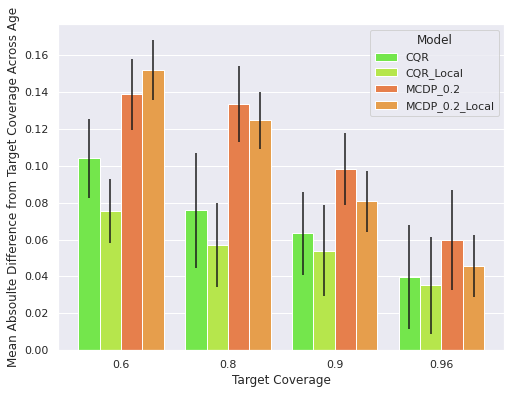

In [69]:
# Comparing Conditional Coverage for dropout and Quantile method
color_palette = []
sns.set(rc={'figure.figsize':(8,6)})


colors = ["#68FF33", "#BFFF33", '#FF7733', '#FF9F33']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(data=df_data_local, x="Target Coverage", y="Mean Absoulte Difference from Target Coverage Across Age", 
                 hue="Model", palette=customPalette)
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df_data_local["MAD Error Rate Age"], fmt="none", c= "k")


<ErrorbarContainer object of 3 artists>

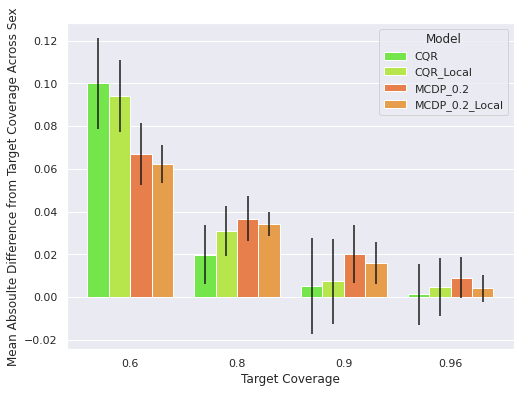

In [70]:
# Comparing Conditional Coverage for dropout and Quantile method
color_palette = []
sns.set(rc={'figure.figsize':(8,6)})


colors = ["#68FF33", "#BFFF33", '#FF7733', '#FF9F33']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(data=df_data_local, x="Target Coverage", y="Mean Absoulte Difference from Target Coverage Across Sex", 
                 hue="Model", palette=customPalette)
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df_data_local["MAD Error Rate Sex"], fmt="none", c= "k")


<ErrorbarContainer object of 3 artists>

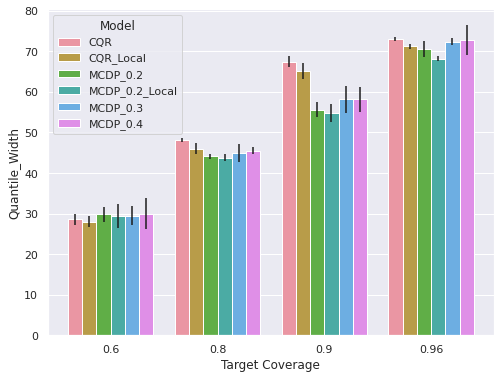

In [71]:
from seaborn.palettes import color_palette
df_data = pd.DataFrame({'Model': ['MCDP_0.2', 'MCDP_0.2_Local', 'MCDP_0.3', 'MCDP_0.4', 'CQR', 'CQR_Local', 
                                  'MCDP_0.2', 'MCDP_0.2_Local', 'MCDP_0.3', 'MCDP_0.4', 'CQR', 'CQR_Local',
                                  'MCDP_0.2', 'MCDP_0.2_Local', 'MCDP_0.3', 'MCDP_0.4', 'CQR', 'CQR_Local',
                                  'MCDP_0.2', 'MCDP_0.2_Local', 'MCDP_0.3', 'MCDP_0.4', 'CQR', 'CQR_Local'],
                   'Quantile_Width': [29.85, 29.43, 29.48, 30.01, 28.54, 28.0,
                                      44.15, 43.78, 44.88, 45.54, 48.12, 46.00,
                                      55.64, 54.74, 58.20, 58.18, 67.43, 65.07,
                                      70.54, 68.19, 72.34, 72.76, 73.026, 71.24],
                   'Quantile_Width_Std': [1.33, .40, 1.40, 1.33, 1.42, 0.4,
                                    1.83, .61, 1.84, 2.02, 2.00, 0.589,
                                    2.22, .64, 2.41, 2.26, 3.01, 0.923,
                                    3.76, .87, 3.04, 3.79, 3.30, 0.860],
                   'Coverage_Naive': [0.20, .20, 0.225, .217, .620, .620,
                                      .30, .30, .34, .33, .874, .874,
                                      .381, .381, .428, .414, .906, .906,
                                      .461, .461, .515, .500, .975, .975], 
                   'Coverage_Naive_Std': [.001, .001, .002, .002, .002, .002,
                                          .002, .002, .002, .001, .001, .001,
                                          .002, .002, .002, .002, .001, .001,
                                          .002, .002, .002, .002, .001, .001],
                   'Coverage_Conformal': [.60, .59, .60, 0.603, .601, .590,
                                          .801, .79, .800, .803, 0.802, .789,
                                          .901, .90, .900, .901, .900, .893,
                                          0.961, .96, .960, .960, .960, 0.957],
                   'Coverage_Std': [.026, .01, .027, .026, .024, .013,
                                    .021, .01, 0.020, .021, .020, .010,
                                    .012, .01, 0.016, .016, .015, 0.009,
                                    0.011, .01, 0.010, 0.011, .010, 0.005],
                   'Target Coverage': [0.6, 0.6, 0.6, 0.6, 0.6,0.6,
                                           0.8, 0.8, 0.8, 0.8, 0.8,0.8,
                                           0.9, 0.9, 0.9, 0.9, 0.9,0.9,
                                           0.96, 0.96, 0.96, 0.96, 0.96, 0.96]})

df_data = df_data.sort_values(by = ["Target Coverage", "Model"])
color_palette = []

ax = sns.barplot(data=df_data, x="Target Coverage", y="Quantile_Width", hue="Model")
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df_data["Quantile_Width_Std"], fmt="none", c= "k")



In [35]:
df_data.head()

,Model,Quantile_Width,Quantile_Width_Std,Coverage_Naive,Coverage_Naive_Std,Coverage_Conformal,Coverage_Std,Target_Error_Rate
22,CQR,73.026,3.30,0.975,0.001,0.960,0.010,0.04
23,CQR_Local,71.240,0.86,0.975,0.001,0.957,0.005,0.04
18,MCDP_0.2,70.540,3.76,0.461,0.002,0.961,0.011,0.04
19,MCDP_0.2_Local,68.190,0.87,0.461,0.002,0.960,0.010,0.04
20,MCDP_0.3,72.340,3.04,0.515,0.002,0.960,0.010,0.04


<ErrorbarContainer object of 3 artists>

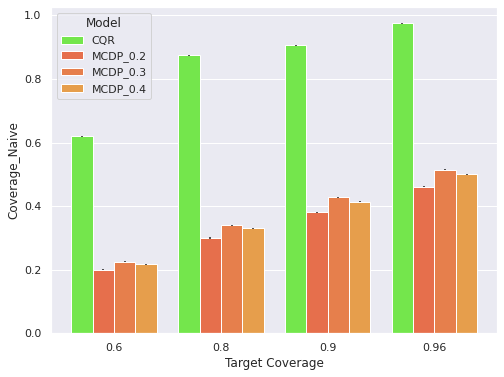

In [72]:
# Comparing Naive Coverage for dropout and Quantile method
color_palette = []
mask_data = df_data.Model.isin(["CQR_Local", "MCDP_0.2_Local"])
df_plot =  df_data[~mask_data]
sns.set(rc={'figure.figsize':(8,6)})


colors = ["#68FF33", "#FF6133", '#FF7733', '#FF9F33']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(data=df_plot, x="Target Coverage", y="Coverage_Naive", hue="Model", palette=customPalette)
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df_plot["Coverage_Naive_Std"], fmt="none", c= "k")


<ErrorbarContainer object of 3 artists>

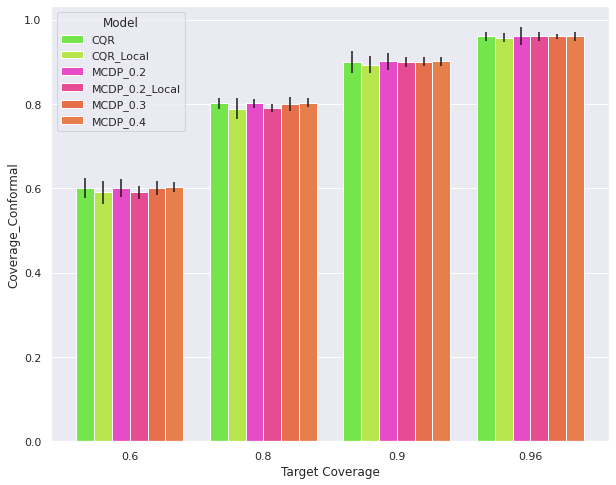

In [73]:
# Comparing Conformal Coverage for dropout and Quantile method
color_palette = []
mask_data = df_data.Model.isin(["CQR_Local", "MCDP_0.2_Local"])
df_plot = df_data
sns.set(rc={'figure.figsize':(10,8)})


colors = ["#68FF33", '#BFFF33', '#FF33D6', '#FF3393',"#FF6133", '#FF7733', '#FF9F33', ]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(data=df_plot, x="Target Coverage", y="Coverage_Conformal", hue="Model", palette=customPalette)
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df_plot["Coverage_Std"], fmt="none", c= "k")


<ErrorbarContainer object of 3 artists>

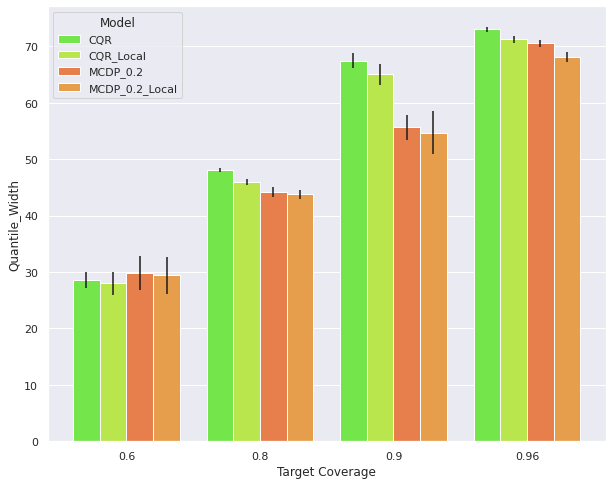

In [74]:
# Local Quantile Width comparision
df_data = df_data.sort_values(by = ["Target Coverage", "Model"])
color_palette = []
mask_data = df_data.Model.isin(["CQR", "CQR_Local", "MCDP_0.2", "MCDP_0.2_Local"])
df_plot =  df_data[mask_data]


colors = ["#68FF33", "#C2FF33", '#FF7733', '#FF9F33']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
ax = sns.barplot(data=df_plot, x="Target Coverage", y="Quantile_Width", hue="Model", palette=customPalette)
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df_plot["Quantile_Width_Std"], fmt="none", c= "k")


In [ ]:
%%time
conditional_width_sex = []
conditional_conformal_coverage_sex = []
conditional_naive_coverage_sex = []
for alpha in alpha_list:

  df_conditional = build_df(final_dict, df, alpha)
  quantile_width, conformal_coverage, naive_coverage = get_conditional_coverage_gender(
    df_conditional, alpha = alpha)
  conditional_naive_coverage_sex.append([np.array(naive_coverage).mean(0), np.array(naive_coverage).std(0)])
  conditional_conformal_coverage_sex.append([np.array(conformal_coverage).mean(0),
                                            np.array(conformal_coverage).std(0)])
  conditional_width_sex.append([np.array(quantile_width).mean(0),
                               np.array(quantile_width).std(0)])

Mean qhat for alpha 0.4 : 10.134 
CPU times: user 297 ms, sys: 1.95 ms, total: 299 ms
Wall time: 300 ms


In [ ]:
conditional_naive_coverage_sex
# alpha = 0.04
# [array([0.41495705, 0.51368851]), array([0.00267201, 0.00298142])]
# alpha = 0.1
# [[array([0.33994272, 0.42901765]), array([0.0029574 , 0.00311816])]]
# alpha = 0.2
# [[array([0.26248355, 0.35434431]), array([0.00221712, 0.00324494])]]
# alpha = 0.4
# [[array([0.16518209, 0.24058285]), array([0.00211689, 0.00252965])]]

[[array([0.16539926, 0.2401979 ]), array([0.00213909, 0.00300154])]]

In [ ]:
conditional_conformal_coverage_sex
# alpha = 0.04
# [array([0.95181315, 0.96991871]), array([0.01138436, 0.00832341])]
# alpha = 0.1
# [[array([0.88204318, 0.92213685]), array([0.01675156, 0.01032369])]]
# alpha = 0.2
# [[array([0.76721076, 0.84033893]), array([0.02330445, 0.01637592])]]
# alpha = 0.4
# [[array([0.53697561, 0.6707417 ]), array([0.02400393, 0.02098422])]]

[[array([0.53908008, 0.67363953]), array([0.02295628, 0.02015007])]]

In [ ]:
conditional_width_sex

[[array([29.44676252, 30.23251419]), array([1.13157074, 1.1319436 ])]]

In [ ]:
#Variance is more for male and may result in narrow coverage.

In [ ]:
%%time
conditional_width_age = []
conditional_conformal_coverage_age = []
conditional_naive_coverage_age = []
for alpha in alpha_list:

  df_conditional = build_df(final_dict, df, alpha)
  quantile_width, conformal_coverage, naive_coverage = get_conditional_coverage_age(
    df_conditional, alpha = alpha)
  conditional_naive_coverage_age.append([np.array(naive_coverage).mean(0),
                                        np.array(naive_coverage).std(0)])
  conditional_conformal_coverage_age.append([np.array(conformal_coverage).mean(0),
                                             np.array(conformal_coverage).std(0)])
  conditional_width_age.append([np.array(quantile_width).mean(0),
                                np.array(quantile_width).std(0)])

Mean qhat for alpha 0.4 : 10.182 
CPU times: user 317 ms, sys: 1.03 ms, total: 318 ms
Wall time: 318 ms


In [ ]:
conditional_naive_coverage_age
# alpha = 0.04
# [[array([0.24309454, 0.53678564, 0.50380814, 0.11446221]),
#  array([0.00903937, 0.00502657, 0.00262379, 0.00469943])]]
# alpha = 0.1
# [[array([0.21455992, 0.46910167, 0.4065133 , 0.09860736]),
#  array([0.00882259, 0.00471391, 0.00246131, 0.00418792])]]
# alpha = 0.2
# [[array([0.19066466, 0.3794917 , 0.3221521 , 0.08086823]),
#   array([0.00674979, 0.00425648, 0.00263252, 0.00381041])]]
# alpha = 0.4
# [[array([0.10173234, 0.25100022, 0.21307034, 0.05250578]),
#   array([0.00545808, 0.00409803, 0.00184836, 0.00268104])]]

[[array([0.10173234, 0.25100022, 0.21307034, 0.05250578]),
  array([0.00545808, 0.00409803, 0.00184836, 0.00268104])]]

In [ ]:
conditional_conformal_coverage_age
# alpha = 0.04
# [[array([0.91218526, 0.96442542, 0.98460388, 0.79801005]),
#  array([0.01982721, 0.0074343 , 0.00467057, 0.03452193])]]
# alpha = 0.1
# [[array([0.81624861, 0.91418108, 0.93738826, 0.6420495 ]),
#  array([0.02204411, 0.01184229, 0.01234654, 0.03207608])]]
# alpha = 0.2
# [[array([0.67622508, 0.82036763, 0.85273808, 0.46321163]),
#   array([0.03205382, 0.01758984, 0.01771356, 0.0309166 ])]]
# alpha = 0.4
# [[array([0.46807267, 0.63933771, 0.65148851, 0.2679212 ]),
#  array([0.02448189, 0.01791985, 0.02495622, 0.02264526])]]

[[array([0.46807267, 0.63933771, 0.65148851, 0.2679212 ]),
  array([0.02448189, 0.01791985, 0.02495622, 0.02264526])]]

In [ ]:
conditional_width_age
# alpha = 0.04
# [[array([73.54955046, 74.3309356 , 68.25241247, 65.80755662]),
#  array([2.76424255, 2.81723558, 2.81244958, 2.7971786 ])]]
# alpha = 0.1
# [[array([58.85727968, 59.15308193, 54.08829988, 52.19429166]),
#  array([1.89977836, 1.96194307, 1.95303611, 1.9438464 ])]]
# alpha = 0.2
# [[array([47.0148309 , 47.17609941, 43.19864099, 41.81485653]),
#   array([1.63835952, 1.66686277, 1.66973862, 1.66725643])]]
# [[array([31.91915757, 31.81953541, 29.34472308, 28.51703038]),
#  array([1.22536848, 1.22408846, 1.22484053, 1.22084483])]]

[[array([31.91915757, 31.81953541, 29.34472308, 28.51703038]),
  array([1.22536848, 1.22408846, 1.22484053, 1.22084483])]]

In [ ]:
from matplotlib.pyplot import plt
import seaborn as sns


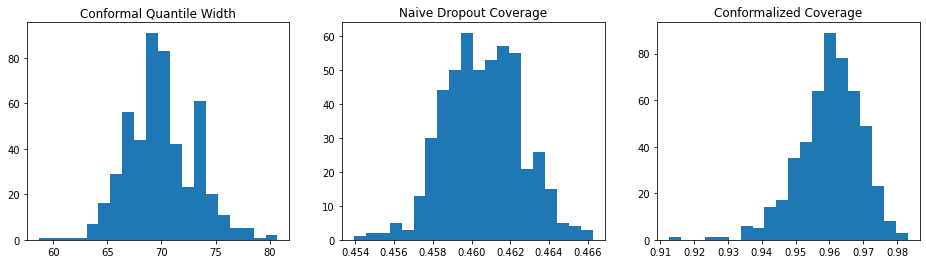

The Quantile width is 69.978 and std is 3.104
The Mean Naive coverage is 0.461 with a std of 0.002
The Mean Conformal coverage is 0.96 with a std of 0.009



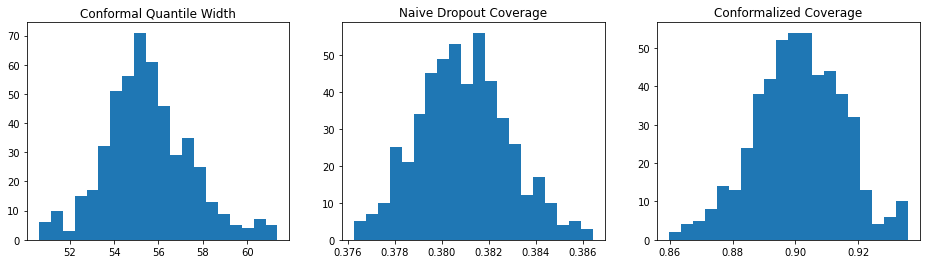

The Quantile width is 55.524 and std is 1.943
The Mean Naive coverage is 0.381 with a std of 0.002
The Mean Conformal coverage is 0.901 with a std of 0.014



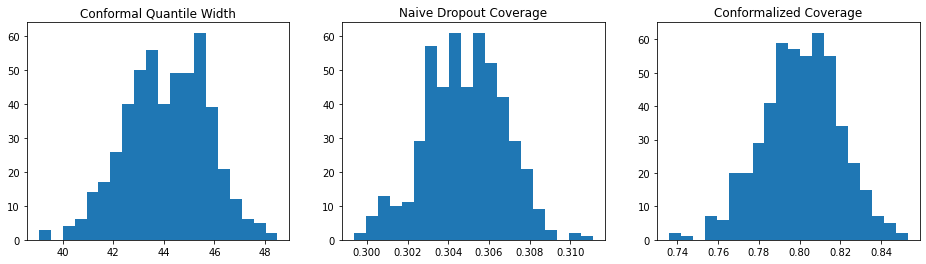

The Quantile width is 44.112 and std is 1.623
The Mean Naive coverage is 0.305 with a std of 0.002
The Mean Conformal coverage is 0.801 with a std of 0.019



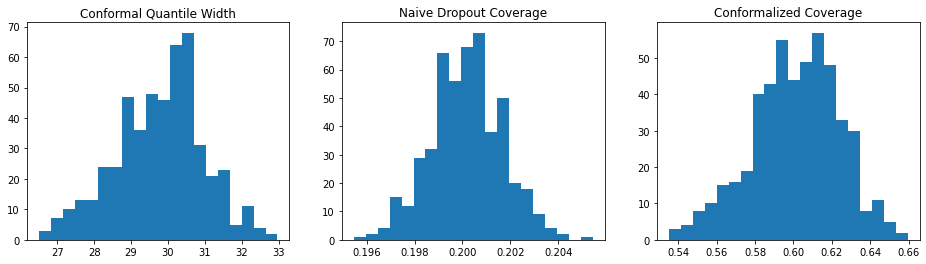

The Quantile width is 29.786 and std is 1.193
The Mean Naive coverage is 0.2 with a std of 0.002
The Mean Conformal coverage is 0.601 with a std of 0.023



In [ ]:
for (quantile_width, conformal_coverage, naive_coverage) in zip(quantile_width_d20_list,
                                                                conformal_coverage_d20_list,
                                                                naive_coverage_d20_list):
  plotting_func(quantile_width, naive_coverage, conformal_coverage)

In [13]:
alpha = 0.2
caliberation_size = 400
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
caliberation_quantiles = dropout_quantiles[:, 0:caliberation_size]
test_quantiles = dropout_quantiles[:, caliberation_size:]
caliberation_target = target_dropout[0:caliberation_size]
test_target = target_dropout[caliberation_size:]
qhat = get_qhat(caliberation_quantiles, caliberation_target, alpha = alpha)
conformal_quantiles = conformilize_quantiles(test_quantiles, qhat)

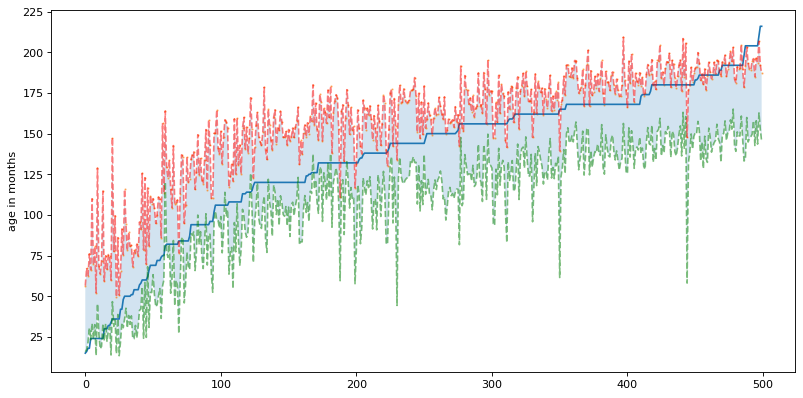

In [15]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

test_target = test_target[0:500]
conformal_quantiles = conformal_quantiles[:, 0:500]
x_values = list(range(len(test_target)))
sorted_index = np.argsort(np.array(test_target))
y_values = np.array(test_target)[sorted_index]
y_lower = conformal_quantiles[0, sorted_index]
y_upper = conformal_quantiles[1, sorted_index]
 
plt.fill_between(x_values, y_lower, y_upper, alpha=0.2) #this is the shaded error
plt.plot(x_values, y_values, alpha = 1) #this is the line itself
# plt.scatter(x_values, y_lower, alpha = 0.5, s= 1)
# plt.scatter(x_values, y_upper, alpha = 0.5, s = 1)
# plt.scatter(x_values, y_lower, color="red", s= 0.1)
# plt.scatter(x_values, y_upper, color="orange", s= 0.1)
plt.plot(x_values, y_lower,linestyle='dashed', color='green', alpha = 0.5)
plt.plot(x_values, y_upper,linestyle='dashed', color='red', alpha = 0.5)
plt.ylabel("age in months")
plt.scatter(x_values, y_upper, alpha = 0.5, s = 1)
plt.show()

In [ ]:
with open('dropout_35_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)


In [ ]:
alpha_list = [0.04, 0.1, 0.2, 0.4]
quantile_width_d35_list = []
conformal_coverage_d35_list = []
naive_coverage_d35_list = []
dropout_quantile_d35_list = []
for alpha in alpha_list:
  print("Running Simulation for alpha of {}".format(alpha))
  dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
  target_dropout = final_dict['age']
  quantile_width_d40, conformal_coverage_d40, naive_coverage_d40 = generate_conformal_sets(dropout_quantiles,
                                                target_dropout, alpha,
                                                caliberation_size = caliberation_size, n_simulation=n_simulation)
  quantile_width_d35_list.append(quantile_width_d40)
  conformal_coverage_d35_list.append(conformal_coverage_d40)
  naive_coverage_d35_list.append(naive_coverage_d40)
  dropout_quantile_d35_list.append(dropout_quantiles)

Running Simulation for alpha of 0.04
Mean qhat for alpha 0.04 : 23.695 
Running Simulation for alpha of 0.1
Mean qhat for alpha 0.1 : 18.753 
Running Simulation for alpha of 0.2
Mean qhat for alpha 0.2 : 14.475 
Running Simulation for alpha of 0.4
Mean qhat for alpha 0.4 : 9.706 


In [ ]:
%%time
conditional_width_sex = []
conditional_conformal_coverage_sex = []
conditional_naive_coverage_sex = []
for alpha in alpha_list:

  df_conditional = build_df(final_dict, df, alpha)
  quantile_width, conformal_coverage, naive_coverage = get_conditional_coverage_gender(
    df_conditional, alpha = alpha)
  conditional_naive_coverage_sex.append(np.array(naive_coverage).mean(0))
  conditional_conformal_coverage_sex.append(np.array(conformal_coverage).mean(0))
  conditional_width_sex.append(np.array(quantile_width).mean(0))

Mean qhat for alpha 0.04 : 23.61 
Mean qhat for alpha 0.1 : 18.766 
Mean qhat for alpha 0.2 : 14.514 
Mean qhat for alpha 0.4 : 9.765 
CPU times: user 1.41 s, sys: 10.3 ms, total: 1.42 s
Wall time: 1.42 s


In [ ]:
conditional_naive_coverage_sex

[array([0.45530398, 0.55769251]),
 array([0.36297122, 0.46602235]),
 array([0.28899319, 0.37021977]),
 array([0.18948768, 0.26286879])]

In [ ]:
conditional_conformal_coverage_sex

[array([0.94880094, 0.97263375]),
 array([0.88379336, 0.91907398]),
 array([0.76827924, 0.83966701]),
 array([0.55741127, 0.6542388 ])]

In [ ]:
conditional_width_sex

[array([72.39572284, 74.01425253]),
 array([57.35561361, 58.8107971 ]),
 array([44.25804317, 45.43911366]),
 array([29.42087659, 30.15350826])]

In [ ]:
%%time
conditional_width_age = []
conditional_conformal_coverage_age = []
conditional_naive_coverage_age = []
for alpha in alpha_list:

  df_conditional = build_df(final_dict, df, alpha)
  quantile_width, conformal_coverage, naive_coverage = get_conditional_coverage_age(
    df_conditional, alpha = alpha)
  conditional_naive_coverage_age.append(np.array(naive_coverage).mean(0))
  conditional_conformal_coverage_age.append(np.array(conformal_coverage).mean(0))
  conditional_width_age.append(np.array(quantile_width).mean(0))

Mean qhat for alpha 0.04 : 23.572 
Mean qhat for alpha 0.1 : 18.907 
Mean qhat for alpha 0.2 : 14.496 
Mean qhat for alpha 0.4 : 9.773 
CPU times: user 1.43 s, sys: 8.48 ms, total: 1.44 s
Wall time: 1.44 s


In [ ]:
conditional_naive_coverage_age

[array([0.28615911, 0.60337128, 0.54102234, 0.13825103]),
 array([0.22191837, 0.49555452, 0.44054139, 0.1182688 ]),
 array([0.19316369, 0.40199917, 0.34644041, 0.09800884]),
 array([0.11530358, 0.29131158, 0.23393714, 0.06188425])]

In [ ]:
conditional_conformal_coverage_age

[array([0.93877379, 0.97670575, 0.97550604, 0.82151772]),
 array([0.8496986 , 0.92540609, 0.9312034 , 0.67913805]),
 array([0.69190968, 0.84827942, 0.83662041, 0.51242228]),
 array([0.50828111, 0.66711385, 0.63232031, 0.3065856 ])]

In [ ]:
conditional_width_age

[array([71.15098945, 76.42294606, 72.95900391, 67.37576028]),
 array([56.59720418, 61.06698516, 58.20659295, 53.92418741]),
 array([43.19988456, 46.89813199, 44.67799026, 41.56122648]),
 array([28.63005753, 31.10714498, 29.71890399, 27.81083279])]

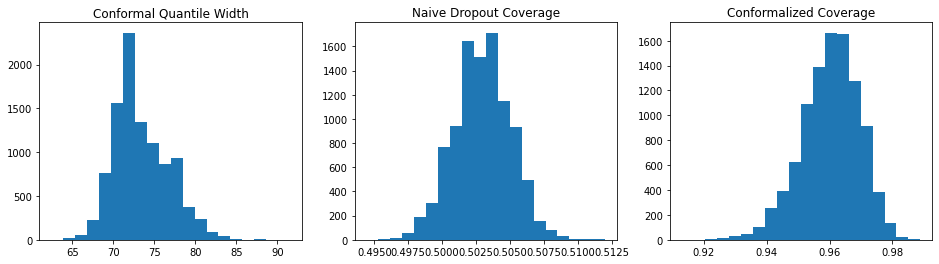

The Quantile width is 73.393 and std is 3.294
The Mean Naive coverage is 0.503 with a std of 0.002
The Mean Conformal coverage is 0.96 with a std of 0.009



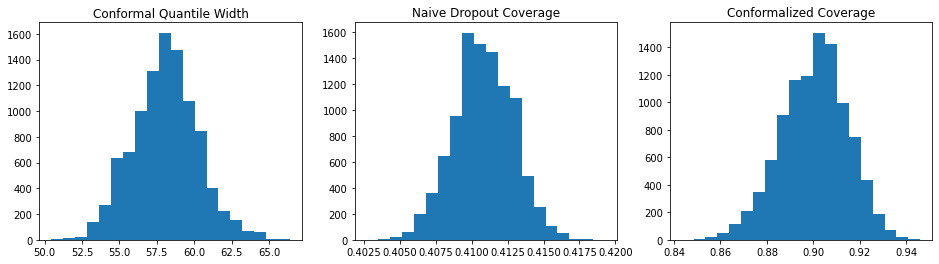

The Quantile width is 58.077 and std is 2.185
The Mean Naive coverage is 0.411 with a std of 0.002
The Mean Conformal coverage is 0.9 with a std of 0.014



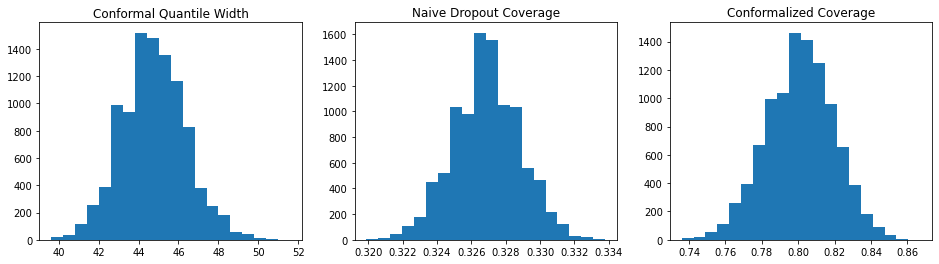

The Quantile width is 44.763 and std is 1.607
The Mean Naive coverage is 0.327 with a std of 0.002
The Mean Conformal coverage is 0.801 with a std of 0.019



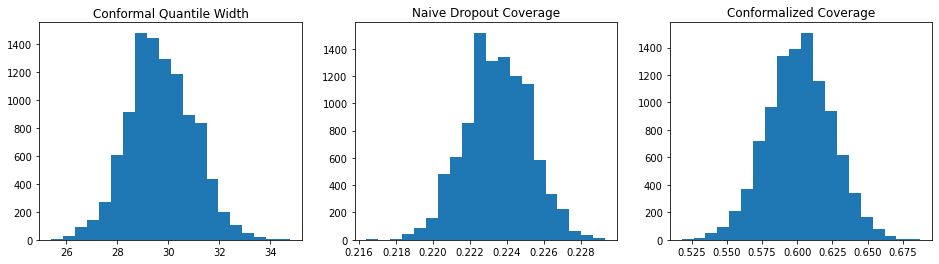

The Quantile width is 29.712 and std is 1.273
The Mean Naive coverage is 0.223 with a std of 0.002
The Mean Conformal coverage is 0.602 with a std of 0.023



In [ ]:
for (quantile_width, conformal_coverage, naive_coverage) in zip(quantile_width_d35_list,
                                                                conformal_coverage_d35_list,
                                                                naive_coverage_d35_list):
  plotting_func(quantile_width, naive_coverage, conformal_coverage)

In [ ]:
with open('dropout_30_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)


In [ ]:
alpha_list = [0.04, 0.1, 0.2, 0.4]
quantile_width_d30_list = []
conformal_coverage_d30_list = []
naive_coverage_d30_list = []
dropout_quantile_d30_list = []
for alpha in alpha_list:
  print("Running Simulation for alpha of {}".format(alpha))
  dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
  target_dropout = final_dict['age']
  quantile_width_d40, conformal_coverage_d40, naive_coverage_d40 = generate_conformal_sets(dropout_quantiles,
                                                target_dropout, alpha,
                                                caliberation_size = caliberation_size, n_simulation=n_simulation)
  quantile_width_d30_list.append(quantile_width_d40)
  conformal_coverage_d30_list.append(conformal_coverage_d40)
  naive_coverage_d30_list.append(naive_coverage_d40)
  dropout_quantile_d30_list.append(dropout_quantiles)

Running Simulation for alpha of 0.04
Mean qhat for alpha 0.04 : 23.762 
Running Simulation for alpha of 0.1
Mean qhat for alpha 0.1 : 18.793 
Running Simulation for alpha of 0.2
Mean qhat for alpha 0.2 : 14.484 
Running Simulation for alpha of 0.4
Mean qhat for alpha 0.4 : 9.744 


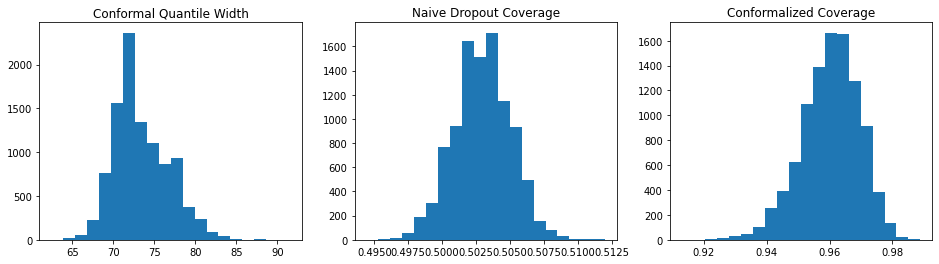

The Quantile width is 73.393 and std is 3.294
The Mean Naive coverage is 0.503 with a std of 0.002
The Mean Conformal coverage is 0.96 with a std of 0.009



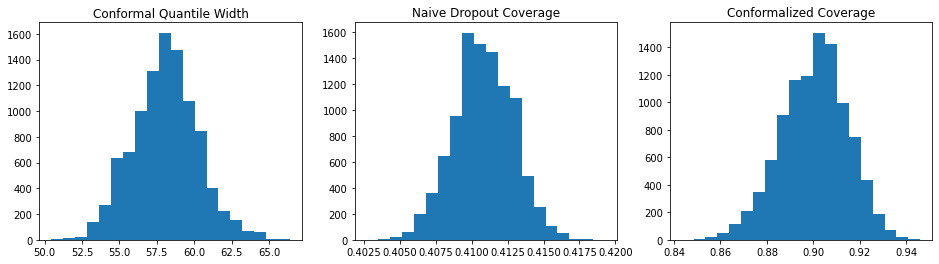

The Quantile width is 58.077 and std is 2.185
The Mean Naive coverage is 0.411 with a std of 0.002
The Mean Conformal coverage is 0.9 with a std of 0.014



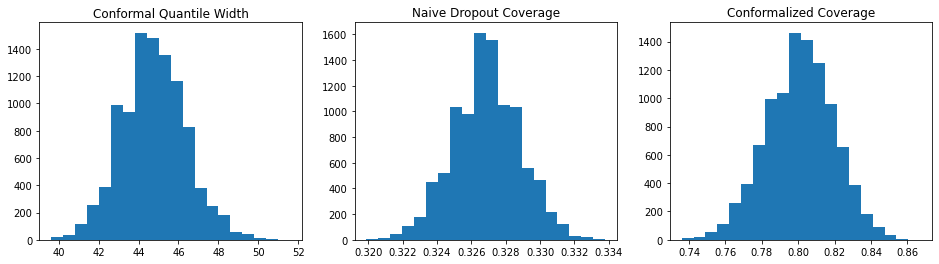

The Quantile width is 44.763 and std is 1.607
The Mean Naive coverage is 0.327 with a std of 0.002
The Mean Conformal coverage is 0.801 with a std of 0.019



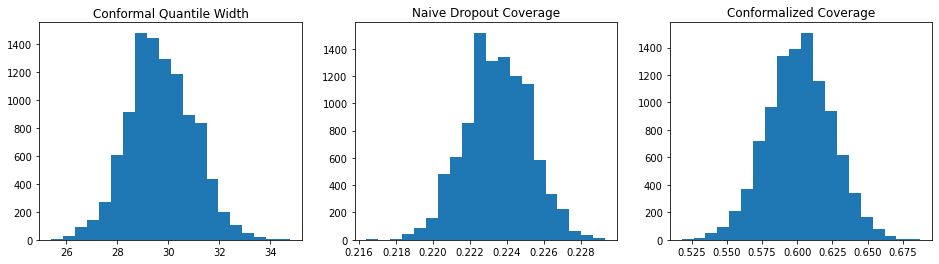

The Quantile width is 29.712 and std is 1.273
The Mean Naive coverage is 0.223 with a std of 0.002
The Mean Conformal coverage is 0.602 with a std of 0.023



In [ ]:
for (quantile_width, conformal_coverage, naive_coverage) in zip(quantile_width_d35_list,
                                                                conformal_coverage_d35_list,
                                                                naive_coverage_d35_list):
  plotting_func(quantile_width, naive_coverage, conformal_coverage)